In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,classification_report
import shap
from xgboost import XGBClassifier
from sklearn import metrics


column_dtypes = {
        	'color':'category'	,'ranking':'category'
}

# Load the dataset
df = pd.read_csv(r"C:\Users\behsh\Desktop\Final assignment of ML\data_water.csv", na_values='', dtype=column_dtypes, sep=',')
X = df.drop(columns=['Potability'])
y = df['Potability']

df.head()





,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,color,ranking,hard_solid
0,NaN,254.125389,9959.135015,4.008584,NaN,364.806273,11.316645,59.353221,3.170543,0,grey,c,2.000527
1,7.580049,225.088554,31749.924400,5.884795,NaN,503.908733,18.502406,78.354341,3.959637,1,light_blue,e,1.993816
2,7.678945,178.200542,20243.088200,7.099474,NaN,363.974060,11.913204,58.273700,3.089550,1,grey,c,2.009952
3,6.149185,150.563593,20596.391230,6.906911,NaN,431.651283,12.829380,64.394907,4.275615,1,green,c,2.002026
4,NaN,187.873284,29532.615000,7.981037,274.493396,469.132117,16.169212,78.925527,4.586748,0,grey,c,2.000303


In [ ]:

#fill N.A
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X.info()

NUM_FEATURES = ['ph'	,'Hardness',	'Solids',	'Chloramines'	,'Sulfate','Conductivity','Organic_carbon','Trihalomethanes'	,'Turbidity','hard_solid']
CAT_FEATURES = ['color'	,'ranking']

# Handling missing values
# Scaling features
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


CAT_FEATURES = X_train.select_dtypes(include='object').columns.to_list()
CAT_FEATURES = ['color', 'ranking'] 



from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  
            ('scaler', StandardScaler())  # Scaling
        ]), NUM_FEATURES),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  
        ]), CAT_FEATURES)
    ],
    remainder="passthrough"  # Keep any features not specified
)


X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
preprocessed_feature_names = preprocessor.get_feature_names_out()

print(f"Transformed X_train shape: {X_train_transformed.shape}")
print(f"Transformed X_test shape: {X_test_transformed.shape}")
print("Feature Names After Transformation:", preprocessor.get_feature_names_out())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ph               2785 non-null   float64 
 1   Hardness         3276 non-null   float64 
 2   Solids           3276 non-null   float64 
 3   Chloramines      3276 non-null   float64 
 4   Sulfate          2495 non-null   float64 
 5   Conductivity     3276 non-null   float64 
 6   Organic_carbon   3276 non-null   float64 
 7   Trihalomethanes  3114 non-null   float64 
 8   Turbidity        3276 non-null   float64 
 9   color            3139 non-null   category
 10  ranking          3155 non-null   category
 11  hard_solid       3276 non-null   float64 
dtypes: category(2), float64(10)
memory usage: 263.3 KB
Transformed X_train shape: (2620, 29)
Transformed X_test shape: (656, 29)
Feature Names After Transformation: ['num__ph' 'num__Hardness' 'num__Solids' 'num__Chloramines' 'num__Sul


Applying PCA...
PCA-transformed X_train shape: (2620, 13)
PCA-transformed X_test shape: (656, 13)

Explained Variance Ratio by PCA Components:
[0.1046374  0.10031145 0.09345369 0.09065317 0.09001905 0.08487033
 0.08401255 0.08238149 0.0778307  0.06685374 0.03260116 0.02375652
 0.02084416]
Number of components to retain 95% variance: 13


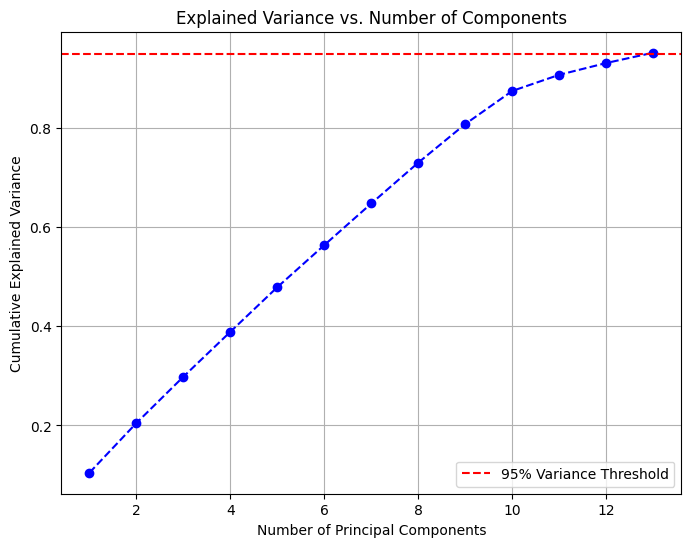

np.float64(8.277822871605167e-13)

In [146]:
#   PCA
# Retain 95% of the variance
print("\nApplying PCA...")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

# Output PCA shapes and explained variance
print(f"PCA-transformed X_train shape: {X_train_pca.shape}")
print(f"PCA-transformed X_test shape: {X_test_pca.shape}")

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print("\nExplained Variance Ratio by PCA Components:")
print(explained_variance)


n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components_95}")

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color="b")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.grid()
plt.show()

X_train_pca.sum()



In [148]:

def performance_evaluation_report(model, X_test, y_test, show_plot=True, labels=None, show_pr_curve=True):
    """
    Function to create a standardized performance evaluation report for models.

    Parameters
    ----------
    model : scikit-learn estimator
        A fitted classification model with `predict` and `predict_proba` methods.
    X_test 
        Test features to evaluate the model on.
    y_test : 
        Ground truth labels for the test set.
    show_plot : 
        Whether to display evaluation plots (confusion matrix, ROC curve, PR curve).
    labels : list, optional
        Class names for axis labels in the confusion matrix.
    show_pr_curve :
        Whether to also display the precision-recall (PR) curve. Requires `show_plot=True`.

    Returns
    -------
    stats : dict
        A dictionary containing various evaluation metrics (accuracy, precision, recall, F1, ROC-AUC.).

    Visual Outputs
    --------------
    - Confusion Matrix
    - ROC Curve
    - Precision-Recall Curve
    """
    # Perform predictions
    y_pred = model.predict(X_test_pca)
    y_pred_prob = model.predict_proba(X_test_pca)[:, 1] 

    # Confusion matrix 
    cm = metrics.confusion_matrix(y_test, y_pred)
    print(metrics.classification_report(y_test, y_pred, target_names=labels))
    tn, fp, fn, tp = cm.ravel()

    # ROC Curve and AUC
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    # Precision-Recall Curve and AUC
    precision, recall, thresholds_pr = metrics.precision_recall_curve(y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    # Calculate G-Mean for ROC thresholds
    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)  

    # Calculate key metrics
    stats = {
        'accuracy': metrics.accuracy_score(y_test, y_pred),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'specificity': tn / (tn + fp),
        'f1_score': metrics.f1_score(y_test, y_pred),
        'roc_auc': roc_auc,
    }

    #  plots
    if show_plot:
        if labels is None:
            labels = ['Negative', 'Positive']

        # Plot Configurations
        n_subplots = 3 if show_pr_curve else 2
        fig, axes = plt.subplots(1, n_subplots, figsize=(16, 6))
        fig.suptitle('Performance Evaluation Report', fontsize=16)

        # Plot Confusion Matrix
        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='Blues',
                    square=True, cbar=False, ax=axes[0], annot_kws={'size': 14})
        axes[0].set_title('Confusion Matrix', fontsize=14)
        axes[0].set_xlabel('Predicted Label', fontsize=12)
        axes[0].set_ylabel('True Label', fontsize=12)
        axes[0].xaxis.set_ticklabels(labels, fontsize=10)
        axes[0].yaxis.set_ticklabels(labels, fontsize=10)

        # Plot ROC Curve
        axes[1].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
        axes[1].plot(fpr[ix], tpr[ix], 'ro', label='Best Threshold', markersize=8)
        axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
        axes[1].set_title('ROC Curve', fontsize=14)
        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].legend(fontsize=11)

        # Plot Precision-Recall Curve 
        if show_pr_curve:
            axes[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            axes[2].set_title('Precision-Recall Curve', fontsize=14)
            axes[2].set_xlabel('Recall', fontsize=12)
            axes[2].set_ylabel('Precision', fontsize=12)
            axes[2].legend(fontsize=11)

        plt.tight_layout(rect=[0, 0, 1, 0.95])  
        plt.show()

    return stats


In [150]:

# Lasso and ridge Regression => no because Classification metrics can't handle a mix of binary and continuous targets
print(df['Potability'].value_counts())
LABELS = ['No Default', 'Default']

# Function to evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n==== Evaluation for {model_name} ====")
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Potability
0    1998
1    1278
Name: count, dtype: int64


Logistic Regression
              precision    recall  f1-score   support

  No Default       0.59      0.49      0.54       400
     Default       0.37      0.46      0.41       256

    accuracy                           0.48       656
   macro avg       0.48      0.48      0.47       656
weighted avg       0.50      0.48      0.49       656



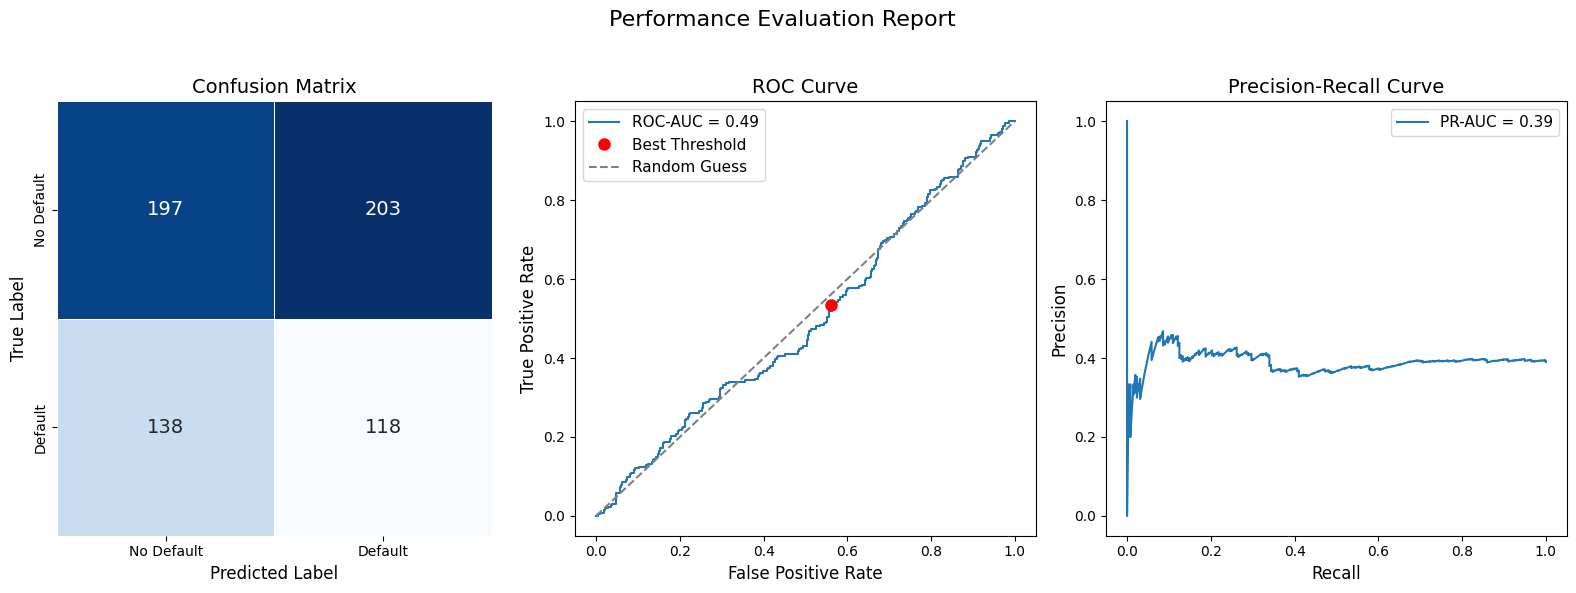

------------------------------------------------------------
  Decision Tree Classifier
              precision    recall  f1-score   support

  No Default       0.64      0.86      0.74       400
     Default       0.54      0.26      0.35       256

    accuracy                           0.62       656
   macro avg       0.59      0.56      0.54       656
weighted avg       0.60      0.62      0.59       656



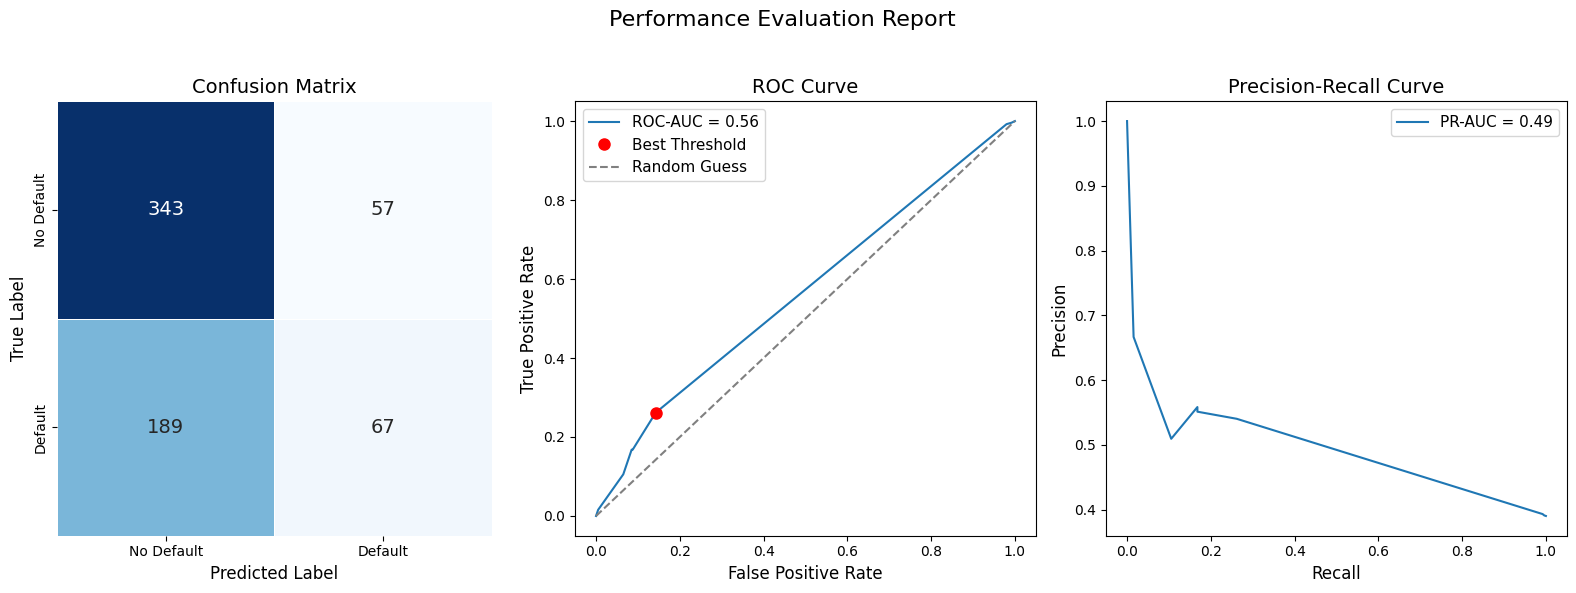

------------------------------------------------------------
Random Forest
              precision    recall  f1-score   support

  No Default       0.65      0.93      0.76       400
     Default       0.66      0.21      0.32       256

    accuracy                           0.65       656
   macro avg       0.66      0.57      0.54       656
weighted avg       0.65      0.65      0.59       656



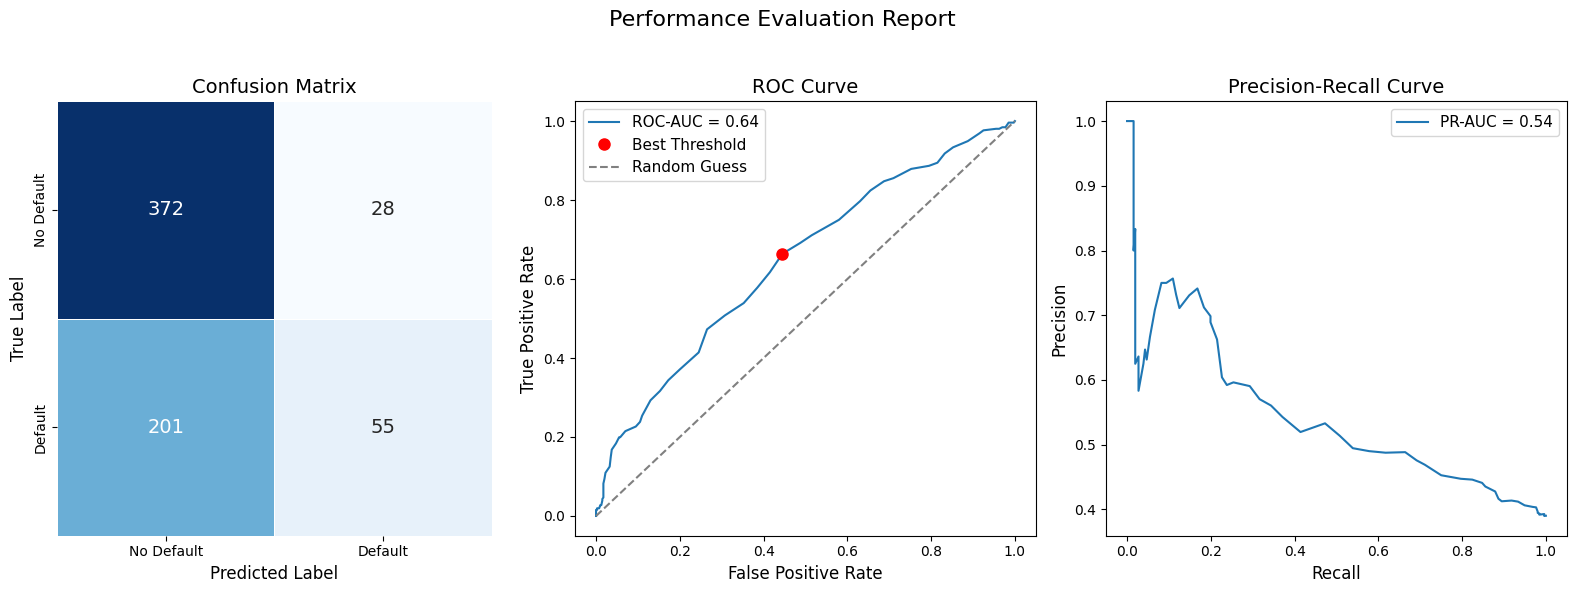

------------------------------------------------------------
Gradient Boosting
              precision    recall  f1-score   support

  No Default       0.64      0.94      0.76       400
     Default       0.64      0.18      0.29       256

    accuracy                           0.64       656
   macro avg       0.64      0.56      0.52       656
weighted avg       0.64      0.64      0.58       656



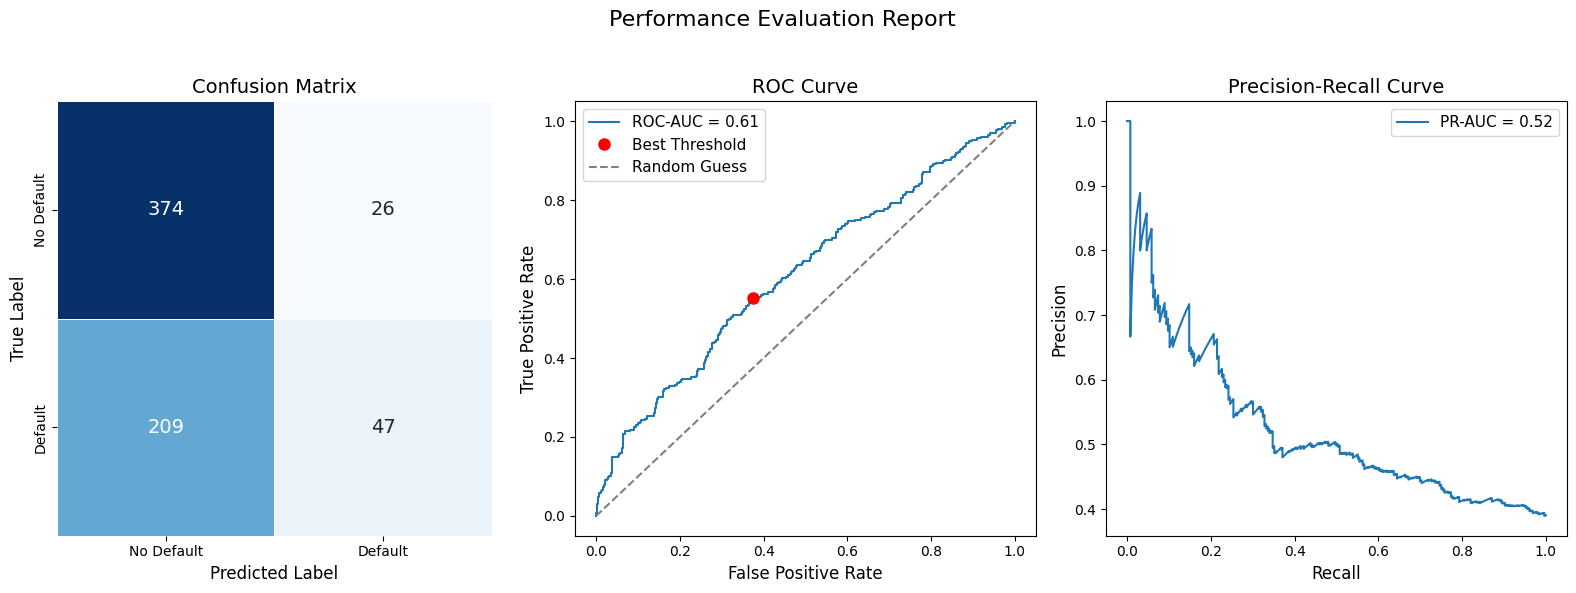

------------------------------------------------------------
XG boost
              precision    recall  f1-score   support

  No Default       0.68      0.71      0.69       400
     Default       0.51      0.47      0.49       256

    accuracy                           0.61       656
   macro avg       0.59      0.59      0.59       656
weighted avg       0.61      0.61      0.61       656



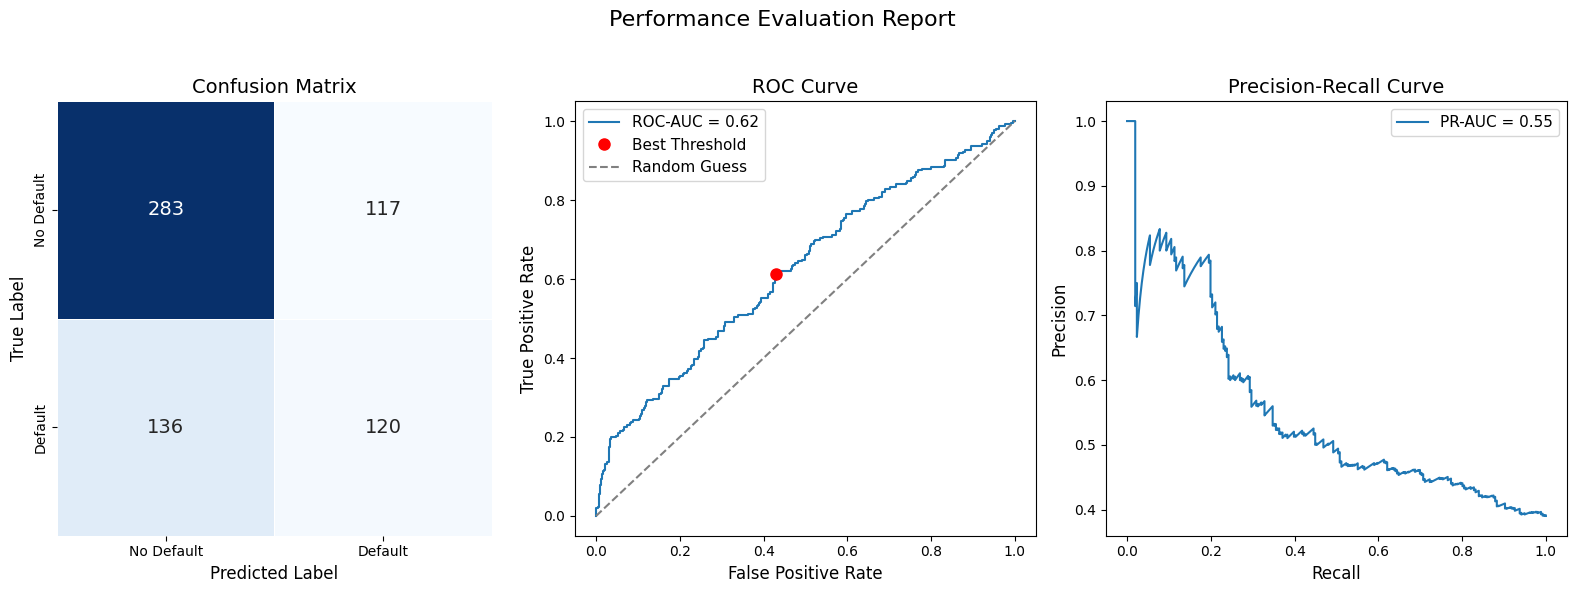

{'accuracy': 0.614329268292683,
 'precision': 0.5063291139240507,
 'recall': 0.46875,
 'specificity': np.float64(0.7075),
 'f1_score': 0.486815415821501,
 'roc_auc': np.float64(0.6248828125)}

In [151]:

# Logistic Regression
print('Logistic Regression')
log_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', class_weight='balanced')
log_model.fit(X_train_pca, y_train)
y_pred_log = log_model.predict(X_test_pca)
performance_evaluation_report(log_model, X_test_pca, y_test,show_plot=True, labels=LABELS, show_pr_curve=True)

print('------------------------------------------------------------')
print('  Decision Tree Classifier')
# Decision Tree Classifier
tree_classifier = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
tree_classifier.fit(X_train_pca, y_train)
y_pred_tree = tree_classifier.predict(X_test_pca)
performance_evaluation_report(tree_classifier, X_test_pca, y_test,show_plot=True, labels=LABELS, show_pr_curve=True)
print('------------------------------------------------------------')

# Random Forest
print('Random Forest')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_pca,y_train)
y_pred_rf = rf_model.predict(X_test_pca)
performance_evaluation_report(rf_model, X_test_pca, y_test,show_plot=True, labels=LABELS, show_pr_curve=True)
print('------------------------------------------------------------')
# Gradient Boosting
print('Gradient Boosting')
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
gb_model.fit(X_train_pca,y_train)
y_pred_gb = gb_model.predict(X_test_pca)
performance_evaluation_report(gb_model, X_test_pca, y_test,show_plot=True, labels=LABELS, show_pr_curve=True)
print('------------------------------------------------------------')
# XGBoost
from xgboost import XGBClassifier
print('XG boost')
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42,enable_categorical=True,color= 'category', ranking= 'category', scale_pos_weight=(y_train.shape[0] - sum(y_train)) / sum(y_train))
xgb_model.fit(X_train_pca,y_train)
y_pred_xgb = xgb_model.predict(X_test_pca)
performance_evaluation_report(xgb_model, X_test_pca, y_test,show_plot=True, labels=LABELS, show_pr_curve=True)


In [152]:

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


==== Evaluation for Logistic Regression ====
Accuracy: 0.4802, Precision: 0.3676, Recall: 0.4609, F1 Score: 0.4090

==== Evaluation for Decision Tree ====
Accuracy: 0.6250, Precision: 0.5403, Recall: 0.2617, F1 Score: 0.3526

==== Evaluation for Random Forest ====
Accuracy: 0.6509, Precision: 0.6627, Recall: 0.2148, F1 Score: 0.3245

==== Evaluation for Gradient Boosting ====
Accuracy: 0.6418, Precision: 0.6438, Recall: 0.1836, F1 Score: 0.2857

==== Evaluation for XGBoost ====
Accuracy: 0.6143, Precision: 0.5063, Recall: 0.4688, F1 Score: 0.4868


In [153]:
#finding best parameter for models
from sklearn.model_selection import GridSearchCV


# Grid search for Logistic Regression
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

log_reg_search = GridSearchCV(LogisticRegression(), log_reg_params, cv=5, scoring='accuracy', n_jobs=-1)
log_reg_search.fit(X_train_pca, y_train)
print(f"Best parameters for Logistic Regression: {log_reg_search.best_params_}")

# Grid search for Decision Tree Classifier
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

tree_search = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='accuracy', n_jobs=-1)
tree_search.fit(X_train_pca, y_train)
print(f"Best parameters for Decision Tree: {tree_search.best_params_}")

# Grid search for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_search.fit(X_train_pca, y_train)
print(f"Best parameters for Random Forest: {rf_search.best_params_}")

# Grid search for Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb_search = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=5, scoring='accuracy', n_jobs=-1)
gb_search.fit(X_train_pca, y_train)
print(f"Best parameters for Gradient Boosting: {gb_search.best_params_}")

# Grid search for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.5,0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = GridSearchCV(XGBClassifier( eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_search.fit(X_train_pca, y_train)
print(f"Best parameters for XGBoost: {xgb_search.best_params_}")

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
best_log_model = Pipeline([
    ('model', LogisticRegression(C=np.float64(0.0003562247890262444), penalty='l2', solver='liblinear'))
])
best_log_model.fit(X_train_pca, y_train)
y_pred_log_best = best_log_model.predict(X_test_pca)


best_rf_model = RandomForestClassifier(
n_estimators = 200, min_samples_split= 5, min_samples_leaf= 2, 
max_features= 'sqrt', max_depth= None, bootstrap= False
)
best_rf_model.fit(X_train_pca, y_train)
y_pred_rf_best = best_rf_model.predict(X_test_pca)


tree_classifier = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10 , min_samples_leaf=10, min_samples_split= 20)
tree_classifier.fit(X_train_pca, y_train)
y_pred_tree_best = tree_classifier.predict(X_test_pca)


best_gb_model = GradientBoostingClassifier(
    learning_rate= 0.1, max_depth= 3, min_samples_leaf= 4,
    min_samples_split= 7, n_estimators= 100, subsample= 0.8
)
best_gb_model.fit(X_train_pca, y_train)
y_pred_gb_best = best_gb_model.predict(X_test_pca)


#XG boosting with transformed data
best_xgb_model =XGBClassifier(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 3, n_estimators= 200, subsample= 0.8, reg_lambda= 1, reg_alpha= 0.5, gamma= 0.4)
best_xgb_model.fit(X_train_pca, y_train)
y_pred_xgb_best = best_xgb_model.predict(X_test_pca)

evaluate_model(y_test, y_pred_log_best, "Logistic Regression")
evaluate_model(y_test, y_pred_tree_best, "Decision Tree")
evaluate_model(y_test, y_pred_rf_best, "Random Forest")
evaluate_model(y_test, y_pred_gb_best, "Gradient Boosting")
evaluate_model(y_test, y_pred_xgb_best, "XGBoost")



==== Evaluation for Logistic Regression ====
Accuracy: 0.6098, Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000

==== Evaluation for Decision Tree ====
Accuracy: 0.6341, Precision: 0.5833, Recall: 0.2188, F1 Score: 0.3182

==== Evaluation for Random Forest ====
Accuracy: 0.6433, Precision: 0.5859, Recall: 0.2930, F1 Score: 0.3906

==== Evaluation for Gradient Boosting ====
Accuracy: 0.6555, Precision: 0.6364, Recall: 0.2734, F1 Score: 0.3825

==== Evaluation for XGBoost ====
Accuracy: 0.6524, Precision: 0.6094, Recall: 0.3047, F1 Score: 0.4062


In [ ]:

best_xgb_model_not_transformed = XGBClassifier(
    colsample_bytree=1.0, learning_rate=0.4, max_depth=4,
    n_estimators=200, subsample=0.8, enable_categorical=True
)
best_xgb_model_not_transformed.fit(X_train, y_train)
y_pred_xgb_best_notrans = best_xgb_model_not_transformed.predict(X_test)
evaluate_model(y_test, y_pred_xgb_best_notrans, "XGBoost without PCA and with train test")
# Grid search for XGBoost with not transformed data
xgb_params_notrans = {
    'n_estimators': [ 200,300,400],
    'learning_rate': [0.005,0.01,0.02,0.4,0.1],
    'max_depth': [ 4, 5, 6,7],
    'subsample': [0.3,0.5,0.6],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search_notrans = GridSearchCV(XGBClassifier( eval_metric='logloss',enable_categorical=True), xgb_params_notrans, cv=5, scoring='accuracy', n_jobs=-1)
xgb_search_notrans.fit(X_train, y_train)
print(f"Best parameters for XGBoost: {xgb_search_notrans.best_params_}")




==== Evaluation for XGBoost without PCA and with train test ====
Accuracy: 0.6204, Precision: 0.5171, Recall: 0.4141, F1 Score: 0.4599


KeyboardInterrupt: 

In [232]:


feature_names = preprocessor.get_feature_names_out()

# Model without PCA for interpretability
gb_model_no_pca = GradientBoostingClassifier(
    learning_rate=0.03, max_depth=6, min_samples_leaf=4,
    min_samples_split=7, n_estimators=70, subsample=0.8
)
gb_model_no_pca.fit(X_train_transformed, y_train)

xgb_model_no_pca = XGBClassifier(
    colsample_bytree=1.0, learning_rate=0.01, max_depth=7,
    n_estimators=400, subsample=0.4, reg_lambda=0, reg_alpha=0.5, gamma=0.4
)
xgb_model_no_pca.fit(X_train_transformed, y_train)
'''
SHAP Analysis at the end'''




'\nSHAP Analysis at the end'

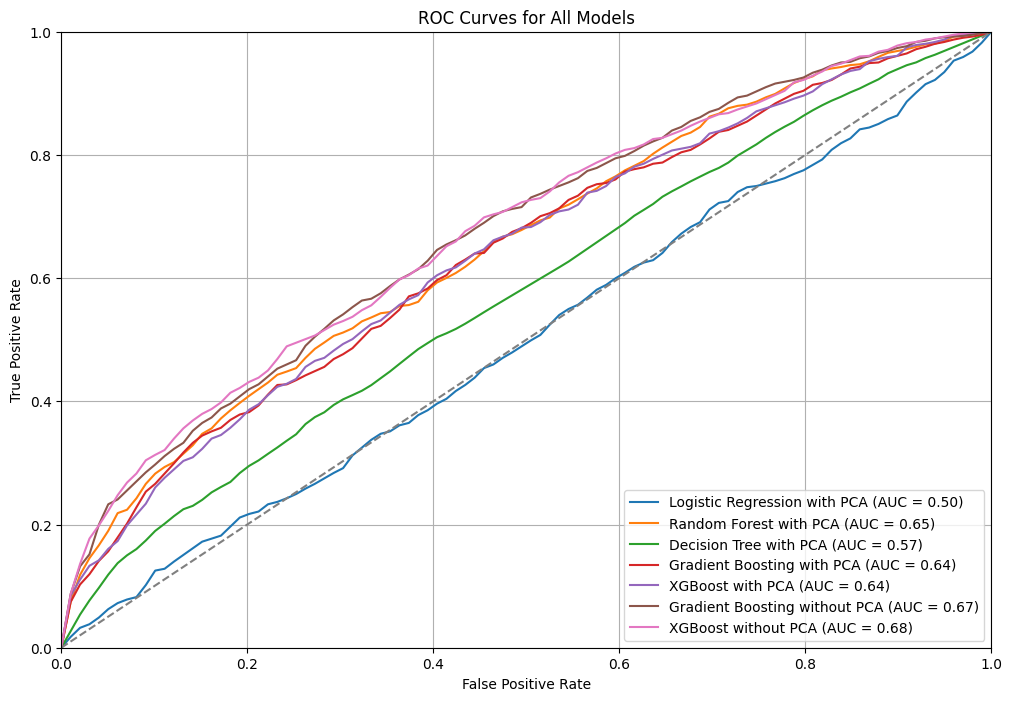

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


y_train_np = np.array(y_train)
cv = StratifiedKFold(n_splits=5)

# plot ROC Curves with Cross-Validation
def plot_cv_roc_curve(models, Xs, names, y):
    plt.figure(figsize=(12, 8))
    
    for model, X, name in zip(models, Xs, names):
        X_np = X if isinstance(X, np.ndarray) else np.array(X)
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)
        
        for train_index, test_index in cv.split(X_np, y):
            # Fit the model and predict probabilities
            probas = model.fit(X_np[train_index], y[train_index]).predict_proba(X_np[test_index])
            # Compute the ROC curve and AUC
            fpr, tpr, _ = roc_curve(y[test_index], probas[:, 1])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        roc_auc = auc(mean_fpr, mean_tpr)
        
        plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


models = [
    best_log_model, best_rf_model, tree_classifier, best_gb_model, best_xgb_model,
    gb_model_no_pca, xgb_model_no_pca 
]

Xs = [
    X_train_pca, X_train_pca, X_train_pca, X_train_pca, X_train_pca,
    X_train_transformed, X_train_transformed 
]

names = [
    'Logistic Regression with PCA', 'Random Forest with PCA', 'Decision Tree with PCA', 'Gradient Boosting with PCA', 'XGBoost with PCA',
    'Gradient Boosting without PCA', 'XGBoost without PCA'
]

plot_cv_roc_curve(models, Xs, names, y_train_np)


In [171]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

results = {}

for model_name, y_pred, y_prob in [
    ("Logistic Regression", y_pred_log_best, best_log_model.predict_proba(X_test_pca)[:, 1]),
    ("Random Forest", y_pred_rf_best, best_rf_model.predict_proba(X_test_pca)[:, 1]),
    ("Decision Tree", y_pred_tree_best, tree_classifier.predict_proba(X_test_pca)[:, 1]),
    ("Gradient Boosting", y_pred_gb_best, gb_model_no_pca.predict_proba(X_test_transformed)[:, 1]),
    ("XGBoost", y_pred_xgb_best, xgb_model_no_pca.predict_proba(X_test_transformed)[:, 1]),  
    ("XGBoost with train data", y_pred_xgb_best_notrans, best_xgb_model_not_transformed.predict_proba(X_test)[:, 1])
]:
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=1)
    auc = roc_auc_score(y_test, y_prob)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    results[model_name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc,
        "Confusion Matrix": conf_mat
    }

# Print results for comparison
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f" {metric}: {value}")
    print("\n" + "-" * 30)

Model: Logistic Regression
 Accuracy: 0.6097560975609756
 Precision: 1.0
 Recall: 0.0
 F1 Score: 0.0
 AUC: 0.48418945312499995
 Confusion Matrix: [[400   0]
 [256   0]]

------------------------------
Model: Random Forest
 Accuracy: 0.6432926829268293
 Precision: 0.5859375
 Recall: 0.29296875
 F1 Score: 0.390625
 AUC: 0.6429199218750001
 Confusion Matrix: [[347  53]
 [181  75]]

------------------------------
Model: Decision Tree
 Accuracy: 0.6341463414634146
 Precision: 0.5833333333333334
 Recall: 0.21875
 F1 Score: 0.3181818181818182
 AUC: 0.58439453125
 Confusion Matrix: [[360  40]
 [200  56]]

------------------------------
Model: Gradient Boosting
 Accuracy: 0.6554878048780488
 Precision: 0.6363636363636364
 Recall: 0.2734375
 F1 Score: 0.3825136612021858
 AUC: 0.638984375
 Confusion Matrix: [[360  40]
 [186  70]]

------------------------------
Model: XGBoost
 Accuracy: 0.6524390243902439
 Precision: 0.609375
 Recall: 0.3046875
 F1 Score: 0.40625
 AUC: 0.6571484375
 Confusion Mat

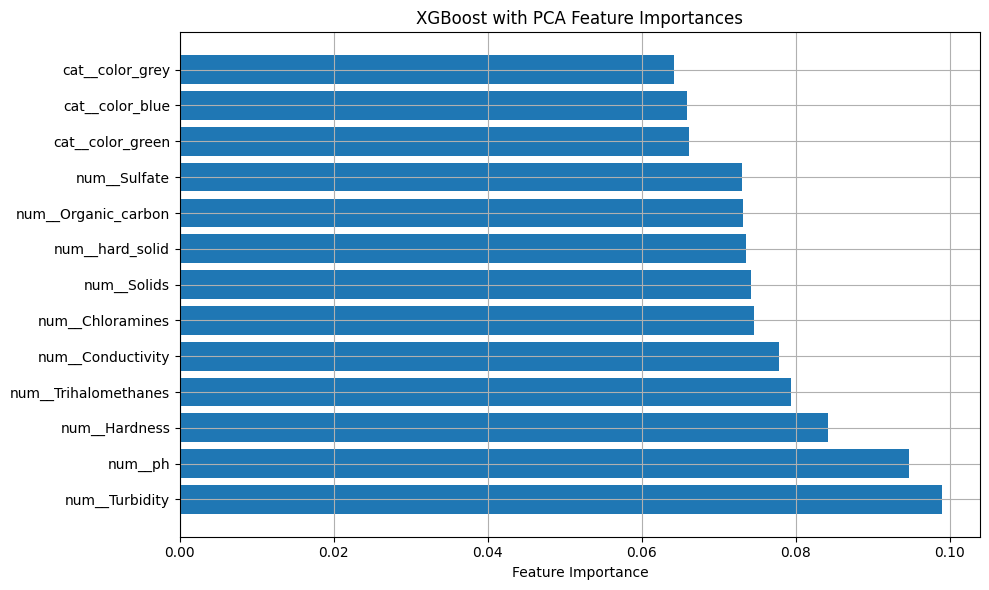

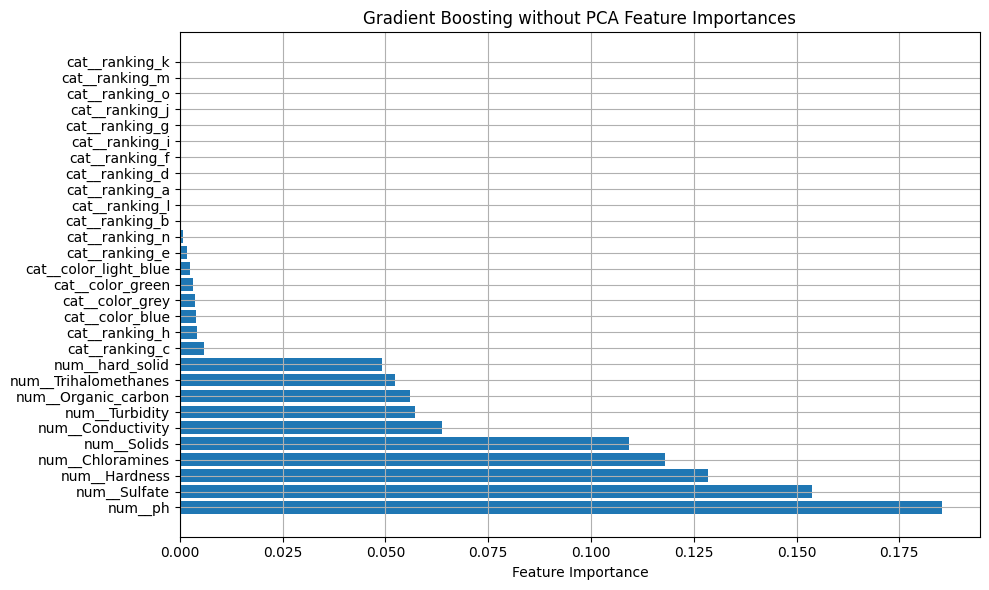

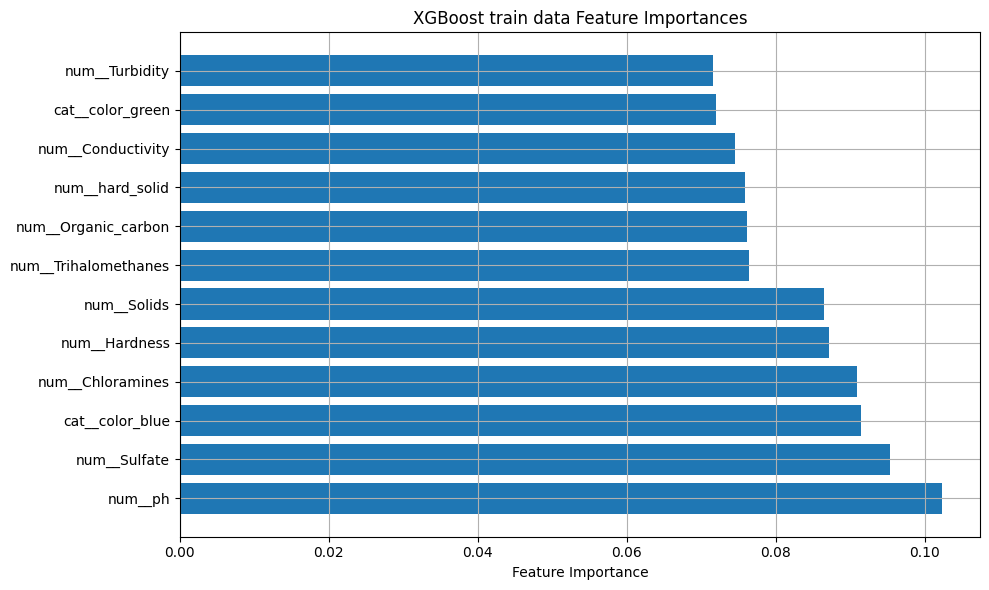

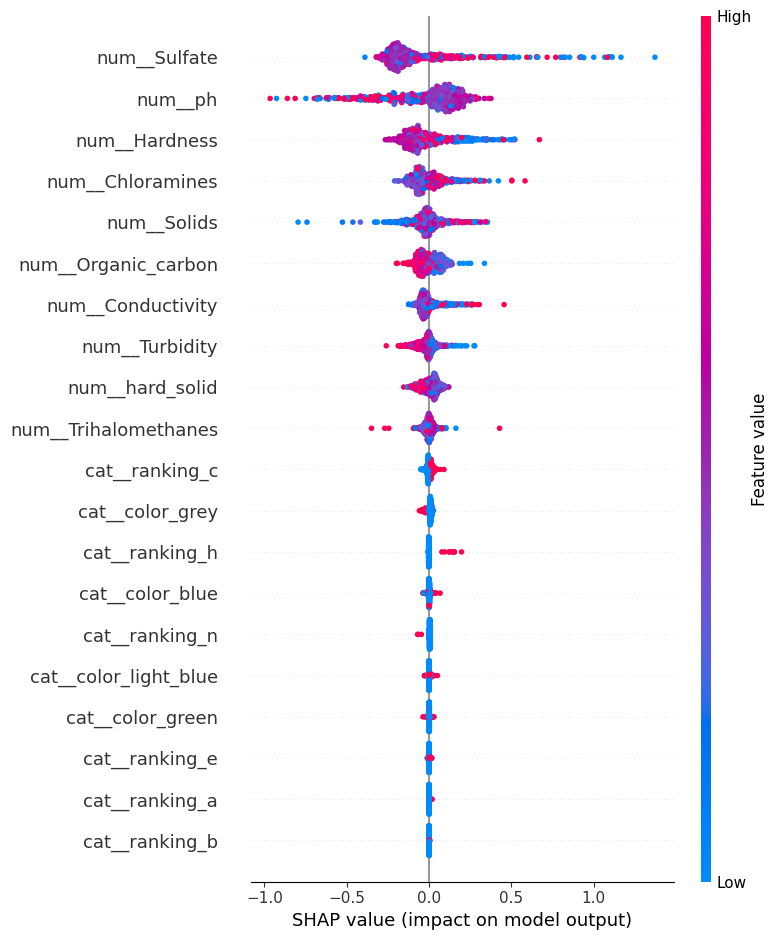

 97%|=================== | 638/656 [00:11<00:00]       

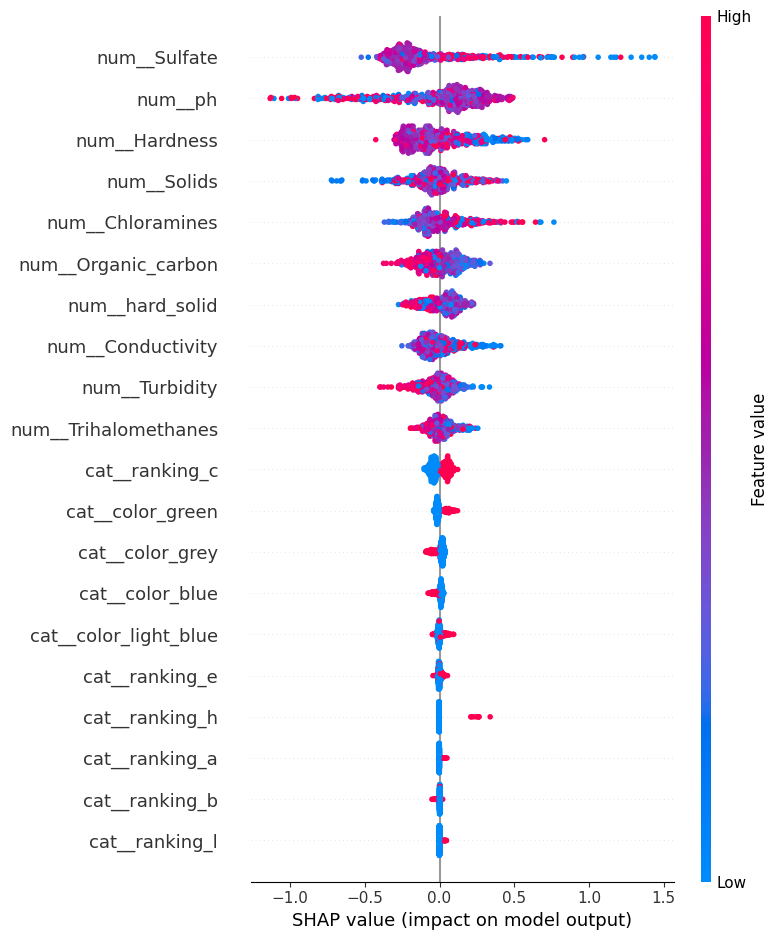


==== Evaluation for Gradient Boosting with PCA ====
Accuracy: 0.6585, Precision: 0.6429, Recall: 0.2812, F1 Score: 0.3913

==== Evaluation for XGBoost with PCA ====
Accuracy: 0.6479, Precision: 0.5926, Recall: 0.3125, F1 Score: 0.4092

==== Evaluation for Gradient Boosting without PCA ====
Accuracy: 0.6448, Precision: 0.6292, Recall: 0.2188, F1 Score: 0.3246

==== Evaluation for XGBoost without PCA ====
Accuracy: 0.6662, Precision: 0.6504, Recall: 0.3125, F1 Score: 0.4222

==== Evaluation for XGBoost without PCA and with train test ====
Accuracy: 0.6204, Precision: 0.5171, Recall: 0.4141, F1 Score: 0.4599


In [231]:
# Feature and SHAP analysis for models without PCA
from sklearn.preprocessing import LabelEncoder


def plot_feature_importances(importances, feature_names, model_name):
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_feature_names = [feature_names[i] for i in sorted_idx]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel('Feature Importance')
    plt.title(f'{model_name} Feature Importances')
    plt.grid()
    plt.tight_layout()
    plt.show()




# For interpretability, focus on models without PCA
# Feature Importance
plot_feature_importances(best_xgb_model.feature_importances_, feature_names, 'XGBoost with PCA')
plot_feature_importances(gb_model_no_pca.feature_importances_, feature_names, 'Gradient Boosting without PCA')
plot_feature_importances(best_xgb_model_not_transformed.feature_importances_, feature_names, 'XGBoost train data')

# SHAP Analysis
explainer_gb = shap.Explainer(gb_model_no_pca, X_train_transformed)
shap_values_gb = explainer_gb(X_test_transformed)
shap.summary_plot(shap_values_gb, X_test_transformed, feature_names=feature_names)

explainer_xgb_nopca = shap.Explainer(xgb_model_no_pca, X_train_transformed)
shap_values_xgb_nopca = explainer_xgb_nopca(X_test_transformed)
shap.summary_plot(shap_values_xgb_nopca, X_test_transformed, feature_names=feature_names)


evaluate_model(y_test, best_gb_model.predict(X_test_pca), "Gradient Boosting with PCA")
evaluate_model(y_test, best_xgb_model.predict(X_test_pca), "XGBoost with PCA")
evaluate_model(y_test, gb_model_no_pca.predict(X_test_transformed), "Gradient Boosting without PCA")
evaluate_model(y_test, xgb_model_no_pca.predict(X_test_transformed), "XGBoost without PCA")
evaluate_model(y_test, y_pred_xgb_best_notrans, "XGBoost without PCA and with train test")


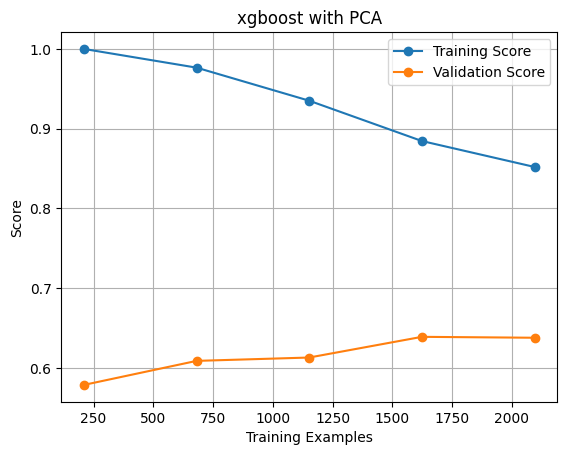

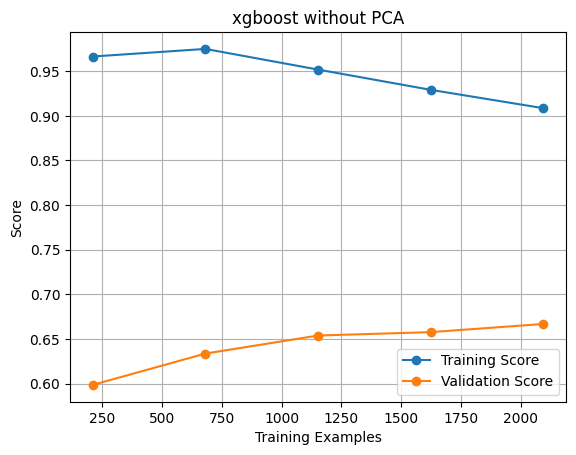

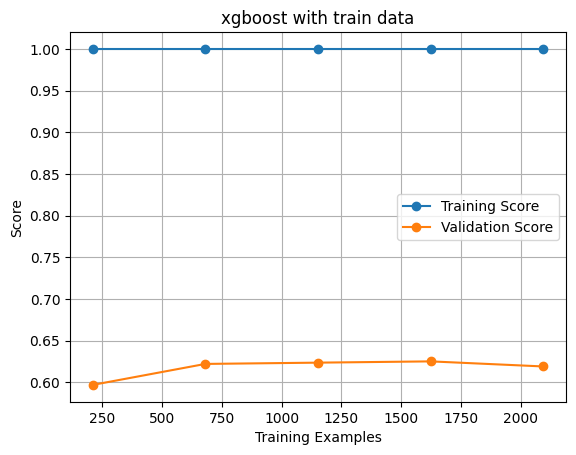

In [186]:
# Learning Curve (Bias-Variance Tradeoff)
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, test_mean, 'o-', label='Validation Score')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
plot_learning_curve(best_xgb_model, X_train_pca, y_train, 'xgboost with PCA')
plot_learning_curve(xgb_model_no_pca, X_train_transformed, y_train, 'xgboost without PCA')
plot_learning_curve(best_xgb_model_not_transformed, X_train, y_train, 'xgboost with train data')


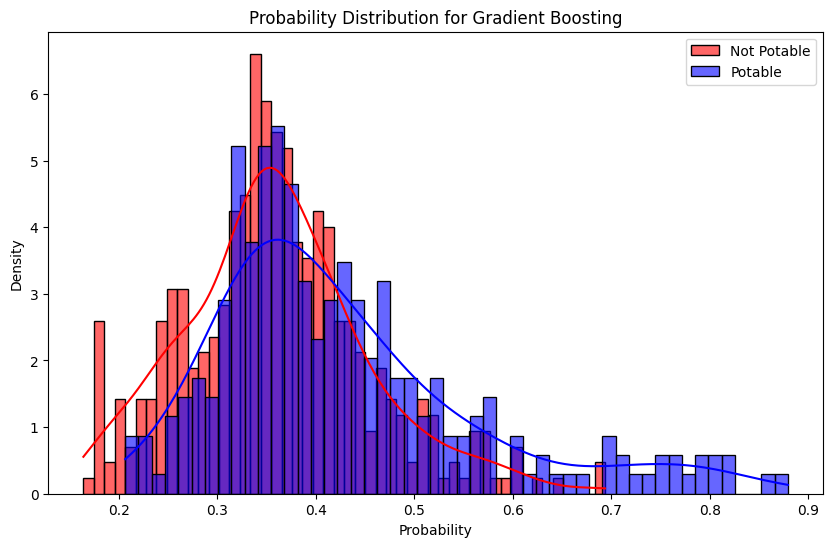

Best threshold for Gradient Boosting: 0.27 with F1-score: 0.5866666666666667


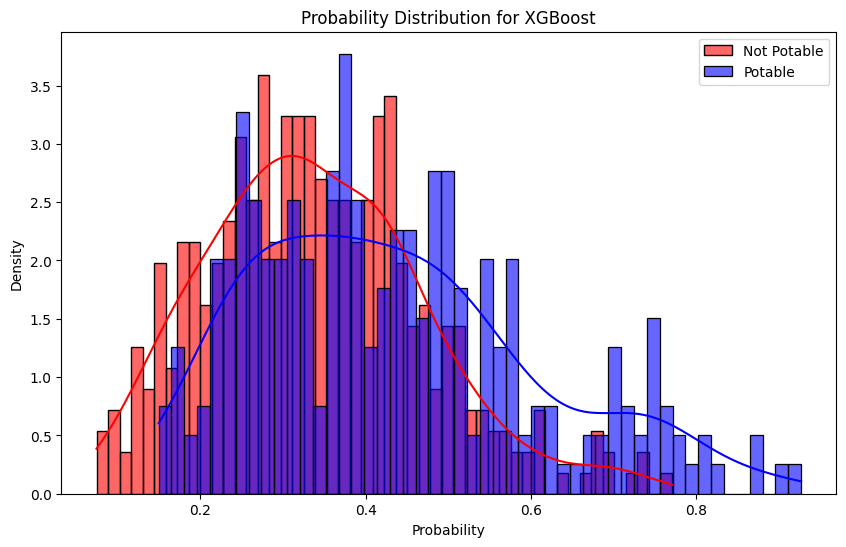

Best threshold for XGBoost: 0.21 with F1-score: 0.5865384615384616


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score

def find_best_alpha(y_test, y_probs):
    thresholds = np.arange(0, 1, 0.01)
    best_threshold = 0
    best_score = 0
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
            
    return best_threshold, best_score

def plot_prob_distribution(model, X_test_pca, y_test, model_name):
    # predicted probabilities for the positive class
    y_probs = model.predict_proba(X_test_pca)[:, 1]

    # Plot distribution of predicted probabilities
    plt.figure(figsize=(10, 6))
    sns.histplot(y_probs[y_test == 0], color='red', label='Not Potable', bins=50, kde=True, stat="density", alpha=0.6)
    sns.histplot(y_probs[y_test == 1], color='blue', label='Potable', bins=50, kde=True, stat="density", alpha=0.6)
    plt.title(f'Probability Distribution for {model_name}')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return y_probs


models = [
    ('Gradient Boosting', gb_model_no_pca),
    ('XGBoost', xgb_model_no_pca)
]

for model_name, model in models:
    y_probs = plot_prob_distribution(model, X_test_transformed, y_test, model_name)
    best_alpha, best_f1 = find_best_alpha(y_test, y_probs)
    print(f"Best threshold for {model_name}: {best_alpha} with F1-score: {best_f1}")


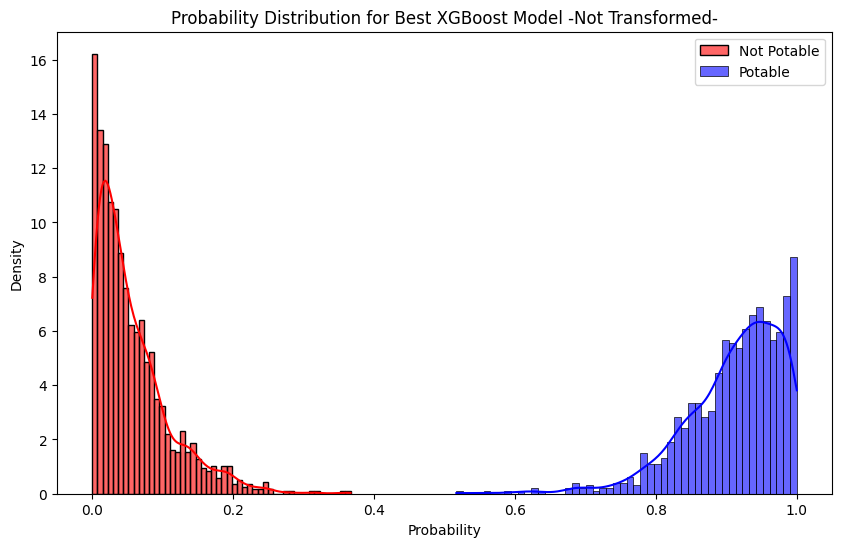

Best Threshold: 0.37
Best F1 Score: 1.00


In [ ]:
def plot_prob_distribution_xgb(model, X_train, y_train, model_name):
    y_probs = model.predict_proba(X_train)[:, 1]
    
    plt.figure(figsize=(10, 6))
    
    
    sns.histplot(y_probs[y_train == 0], color='red', label='Not Potable', bins=50, kde=True, stat="density", alpha=0.6)
    sns.histplot(y_probs[y_train == 1], color='blue', label='Potable', bins=50, kde=True, stat="density", alpha=0.6)
 
    plt.title(f'Probability Distribution for {model_name} ,only on Train Data')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()



def find_best_threshold(y_true, y_probs):
    """
    :param y_true: True binary labels
    :param y_probs: Predicted probabilities for the positive class
    :return: Best threshold and the corresponding F1-score
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.0
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        current_score = f1_score(y_true, y_pred)
        
        if current_score > best_score:
            best_score = current_score
            best_threshold = threshold
            
    return best_threshold, best_score


y_probs_train = plot_prob_distribution(best_xgb_model_not_transformed, X_train, y_train, 'Best XGBoost Model -Not Transformed-')  
best_thresh, best_f1 = find_best_threshold(y_train, y_probs_train)

print(f"Best Threshold: {best_thresh:.2f}")
print(f"Best F1 Score: {best_f1:.2f}")

print('My final model is this one^-^')

In [ ]:
import joblib
import pandas as pd

joblib.dump(best_xgb_model_not_transformed, 'xgboost_model.joblib')

FEATURES = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 
            'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'color', 'ranking', 'hard_solid']

# Load trained model
xgboost_model = joblib.load('xgboost_model.joblib')

def get_user_input():
    user_input = {}
    # numeric feature inputs
    for feature in FEATURES:
        if feature in ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 
                       'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'hard_solid']:
            user_input[feature] = float(input(f"Please enter the value for {feature}: "))
        else:  # Categorical features
            user_input[feature] = input(f"Please enter the value for {feature}: ")


    user_input_df = pd.DataFrame([user_input])
    user_input_df = user_input_df[FEATURES]
    user_input_df['color'] = user_input_df['color'].astype('category')
    user_input_df['ranking'] = user_input_df['ranking'].astype('category')

    return user_input_df
user_input_df = get_user_input()

# Prediction
try:
    prob = xgboost_model.predict_proba(user_input_df)[:, 1][0]
    threshold = 0.37
    predictions = {
        'XGBoost': "Potable" if prob >= threshold else "Not potable"
    }
    print(f"🔹 XGBoost - Probability of potability of water: {prob:.4f} => {predictions['XGBoost']}")
except AttributeError:
    pred = xgboost_model.predict(user_input_df)[0]
    predictions = {
        'XGBoost': "Potable" if pred == 1 else "Not potable"
    }
    print(f"🔹 XGBoost - Prediction of potability of water: {pred} => {predictions['XGBoost']}")

print(' I got the potability of 99 % with these input : 7,	180,	29900,	5	,250,	420	,14	,91	,4.5,	light_blue	,c	,1.98')

🔹 XGBoost - Probability of potability of water: 0.9964 => Potable
 I got the potability of 97 % with these input : 7,	180,	29900,	5	,250,	420	,14	,91	,4.5,	light_blue	,c	,1.98
